# SISO for a Ground Motion Event

In [1]:
import mdof
from mdof import modal, transform
from scipy import integrate, differentiate
import numpy as np
from mdof.utilities.config import Config
from mdof.utilities.printing import print_modes, plot_transfer, plot_io, plot_pred
import matplotlib.pyplot as plt
from plotly import graph_objects as go, express as px

## Unknown system with one input and one output
parameter | value
----------|-------
$\omega_n$  | natural period
$\zeta$  | damping ratio

![sdof2](../figures/sdof2.png)

## Configure

### Inputs: [El Centro Earthquake](https://www.youtube.com/shorts/6DVtmpsuugA)

In [2]:
inputs  = np.loadtxt("../uploads/elcentro.txt")
dt = 0.01
time = np.linspace(0, len(inputs)*dt, len(inputs))

fig = px.line(x=time, y=inputs, title='Input acceleration over time')
fig.update_layout(xaxis_title='time (s)', yaxis_title='acceleration (g)')
fig.show()

### Outputs

In [3]:
# Example SDOF system

mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio

def governing_equation(t,u,inputs,time,m,c,k):
    """"
    Return the derivative of the state `u`=[displ,veloc]
    according to the governing equation of the 
    damped harmonic oscillator
    """
    displ = u[0]
    veloc = u[1]
    i_time = np.max(np.where(time<=t)[0]) # index of most recent time sample
    delta_t = t-time[i_time] # time since most recent time sample
    slope = (inputs[i_time+1]-inputs[i_time])/(time[i_time+1]-time[i_time]) # current slope of input/time
    inputs_t = inputs[i_time] + delta_t*slope # input at the current time
    return [veloc, inputs_t-(c/m)*veloc-(k/m)*displ]

In [4]:
omega_n = np.sqrt(k/mass)  # natural frequency (rad/s)
Tn = 2*np.pi/omega_n  # natural periods (s)
c = 2*zeta*mass*omega_n    # damping coefficient

print(f"natural period: {Tn:<3.5}s")
print(f"damping ratio:  {zeta}")

# Solve the differential equation numerically to determine displacement and velocity
displ,veloc = integrate.solve_ivp(fun=lambda t,u: governing_equation(t,u,inputs,time,mass,c,k),
                            t_span=(time[0], time[-2]),
                            y0=[0,0],
                            t_eval=time[:-1],
                            dense_output=True
                            ).y
# Compute acceleration from velocity using central difference method
outputs = veloc[2:]-veloc[:-2]/(2*dt)

natural period: 1.1471s
damping ratio:  0.01


In [5]:
# Account for lost timesteps from use of forward integration and central difference method
time = time[1:-2]
displ = displ[1:-2]
veloc = veloc[1:-2]
inputs = inputs[1:-2]

In [6]:
fig = px.line(x=time, y=outputs, title='Output acceleration over time')
fig.update_layout(xaxis_title='time (s)', yaxis_title='acceleration (g)')
fig.show()

## Analysis with System Identification

### Transfer Function Methods

In [7]:
# Set parameters
conf = Config()
conf.damping = zeta
conf.period_band = (0.1,3) # Period band (s)
conf.pseudo = True # use pseudo accelerations (Sa)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = transform.fourier_transfer(inputs, outputs, dt, **conf)
transfer_models["Response Spectrum"] = transform.response_transfer(inputs, outputs, dt, **conf)

# Determing the fundamental frequency
fourier_periods, fourier_amplitudes = modal.spectrum_modes(*transfer_models["Fourier Transform"])
response_periods, response_amplitudes = modal.spectrum_modes(*transfer_models["Response Spectrum"], height=10)

### State Space Methods

In [8]:
# Generate a state space realization of the system
conf.order = 2
conf.horizon = 300
realization = mdof.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
print_modes(ss_modes, Tn=Tn, zeta=zeta)


Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      1.147      0.01071    1.0        1.0        1.0          0.003598     7.11     
Mean Period(s): 1.147188721423527
Standard Dev(s): 0.0


### Visualize Transfer Functions vs. State Space Methodds

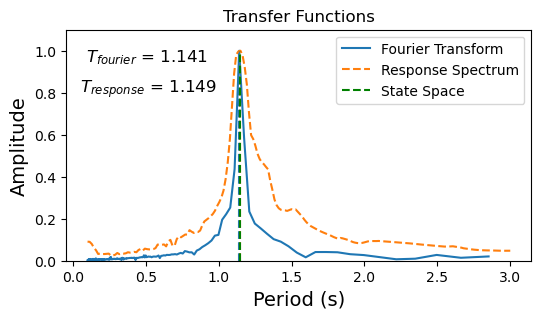

In [9]:
plot_transfer(transfer_models, title="Transfer Functions")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gcf().axes[0].vlines([fourier_periods[0], response_periods[0]],ymin=0,ymax=1,linestyles='--',colors=color_cycle[:2])
plt.gcf().axes[0].vlines(1/ss_modes[next(iter(ss_modes.keys()))]["freq"],ymin=0,ymax=1,linestyles='--',colors='g',label="State Space")
plt.gcf().axes[0].legend()
plt.gcf().axes[0].text(fourier_periods[0]-1.05,0.95,r"$T_{fourier}$ = "+str(np.round(fourier_periods[0],3)),fontsize=12)
plt.gcf().axes[0].text(response_periods[0]-1.1,0.8,r"$T_{response}$ = "+str(np.round(response_periods[0],3)),fontsize=12)
plt.gcf().axes[0].set_ylim((0,1.1));

In [10]:
assert np.isclose(1/Tn, ss_modes[next(iter(ss_modes.keys()))]["freq"], atol=1e-2), (1/Tn, 1/ss_modes[next(iter(ss_modes.keys()))]["freq"])
assert np.isclose(Tn, fourier_periods[0], atol=1e-2)

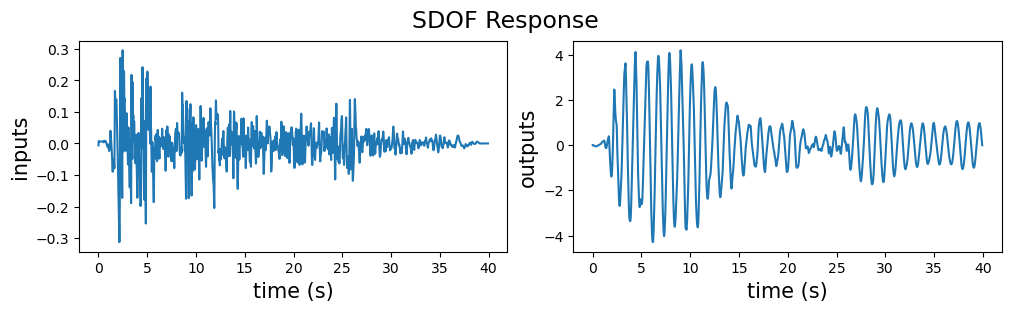

In [11]:
fig = plot_io(inputs=inputs, outputs=outputs, t=time, title="SDOF Response")

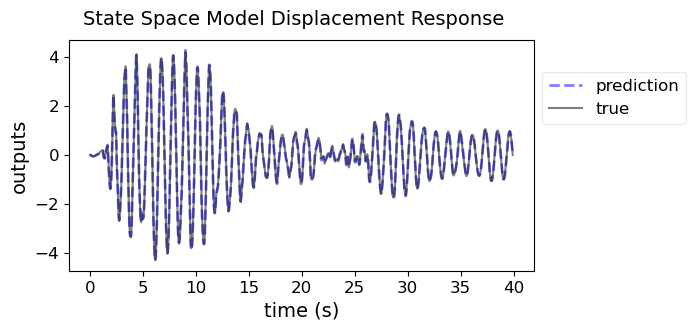

In [12]:
# Reproduce the response with the state space model
from control import ss, forced_response
out_mdof = forced_response(ss(*realization,dt), U=inputs, squeeze=False, return_x=False).outputs
fig = plot_pred(ytrue=outputs, models=out_mdof, t=time, title="State Space Model Displacement Response")